# Calculate residuals, colocate ICESAT1 points explore with 


Huw said:
You can calculate the residuals from the track*_all_dzdt.mat files in /Users/home/horganhu/ICESAT_LINK/TAMATA_ICESAT/GLA12_633_DZDT/
```
track0099_all_dzdt.mat
dzdt.track0099.bin2963.grad,
dzdt.track0099.bin2963.dzdt,
dzdt.track0099.bin2963.x,
dzdt.track0099.bin2963.y,
dzdt.track0099.bin2963.z,
dzdt.track0099.bin2963.retide,
dzdt.track0099.bin2963.sdatedays,
dzdt.track0099.bin2963.elev_wgs84_tpxtide,
dzdt.track0099.bin2963.lat,
dzdt.track0099.bin2963.lon,
dzdt.track0099.bin2963.ret
```


```matlab
zp = [x-mean(x); y-mean(y)]'*grad + (t-t0)'*(bindzdt) + mean(z); % Note here we use z here (not elev)

zp=zp';

res = z - zp;     % transient changes (footprint elevation changes corrected for
                % slope and secular change. Note here we use z here (not elev)
                
dz=res + ((t - t0).*bindzdt);   % Elevation change corrected for each segment. This is
                % corrected for gradient. Note, this is per day.
```                

- so I think that, zp is essentially corrected height

- res is change between correct height and original height

- dz is change in height over time

In [1]:
import sys
import h5py
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from shapely.ops import nearest_points
import numpy as np
from tqdm import tqdm

sys.path.append('/Users/home/whitefar/DATA/code/REMOTE_SENSING/ICESAT/')

from icesat1_calculate_residuals import icesat1_load_alldzdt_pickle, icesat1_alldzdt_todataframe



### See more code at
```
/Users/home/whitefar/DATA/code/REMOTE_SENSING/ICESAT/icesat1_calculate_residuals.py
```

1.  I used icesat1_alldzdt_todataframe() to reorganise *_all_dzdt.mat files
2. load the files with icesat1_load_alldzdt_pickle

In [2]:
paths = glob.glob('/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/*_alldzdt.pkl')
tracks = [path[-21:-12] for path in paths]
for track in tracks:
    da = icesat1_load_alldzdt_pickle(track)
    print(track,da.shape)
    del da
    

track1331 (0, 17)
track0141 (0, 17)
track0043 (0, 17)
track1303 (0, 17)
track0057 (0, 17)
track0225 (0, 17)
track0407 (0, 17)
track0169 (0, 17)
track0127 (0, 17)
track0267 (0, 17)
track0365 (0, 17)
track0015 (0, 17)
track0197 (0, 17)
track0001 (0, 17)
track1317 (0, 17)
track0071 (0, 17)
track0309 (0, 17)
track1289 (0, 17)
track0183 (0, 17)
track0029 (0, 17)
track0155 (0, 17)
track0323 (0, 17)
track0351 (0, 17)
track0281 (0, 17)
track0393 (0, 17)
track1275 (0, 17)
track0085 (0, 17)
track0113 (0, 17)
track0295 (0, 17)
track0337 (0, 17)
track0211 (672, 17)
track0099 (1062, 17)
track0379 (0, 17)
track1345 (0, 17)
track0239 (0, 17)
track0253 (0, 17)


In [4]:
def map_track(track,show='zp'):
    da = icesat1_load_alldzdt_pickle(track)
    gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")
    plt.figure(figsize=(15,15))
    plt.scatter(da.x,da.y,c=da[show],cmap='Spectral_r')
    plt.plot(gd_chan.iloc[75:-300:10].geometry.x,gd_chan.iloc[75:-300:10].geometry.y,'g:')
    plt.legend(['surface channel low','melt_rate'])
    cb = plt.colorbar()
    cb.set_label(show)
    plt.grid()

In [17]:
def crosssection(track,x_or_y = 'y',show='zp'):
    da = icesat1_load_alldzdt_pickle(track)
    gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")
    
    plt.figure(figsize=(15,6))
    for pass_date in da.timestamp.dt.date.unique():
        daa = da[da.timestamp.dt.date==pass_date]
        plt.plot(daa[x_or_y],daa[show],'x',label=pass_date)
    plt.xlim([da[x_or_y].min(),da[x_or_y].max()])
    plt.legend()
    plt.grid()

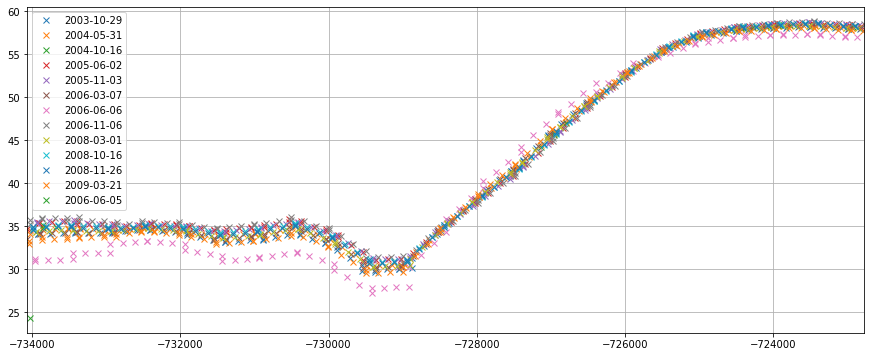

In [18]:
crosssection('track0099',show='zp')

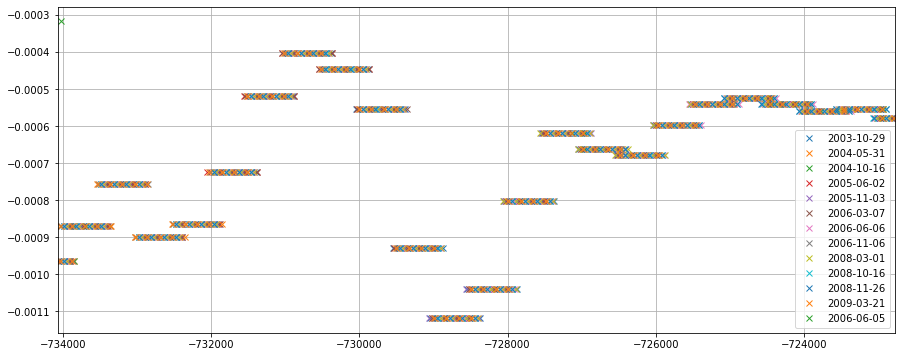

In [19]:
crosssection('track0099',show='dzdt')

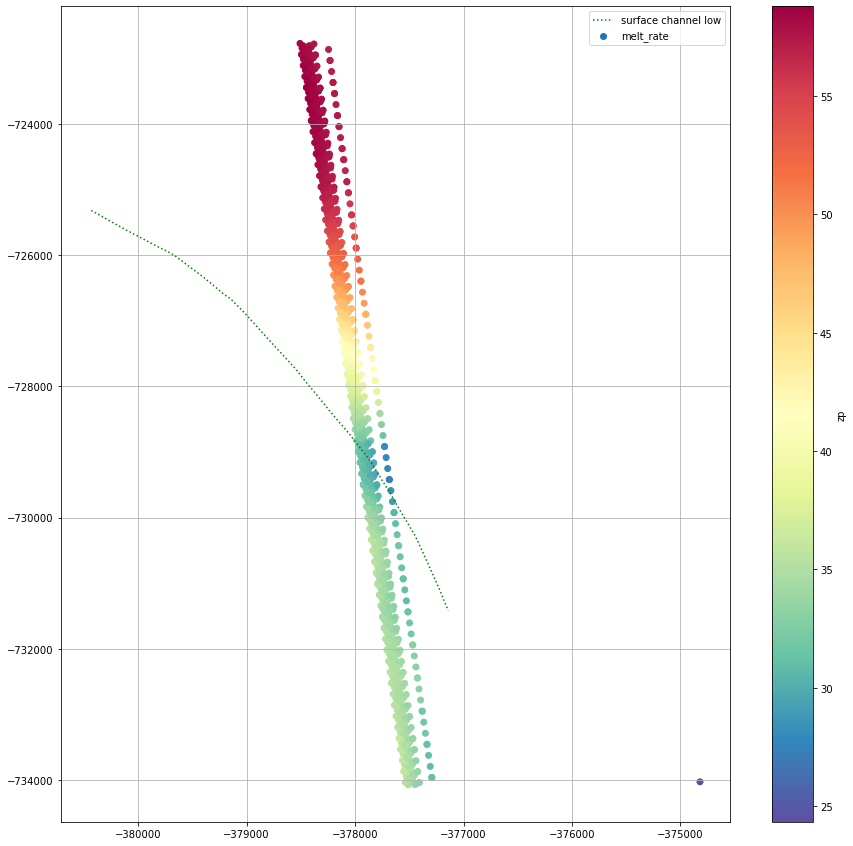

In [8]:
map_track('track0099',show='zp')

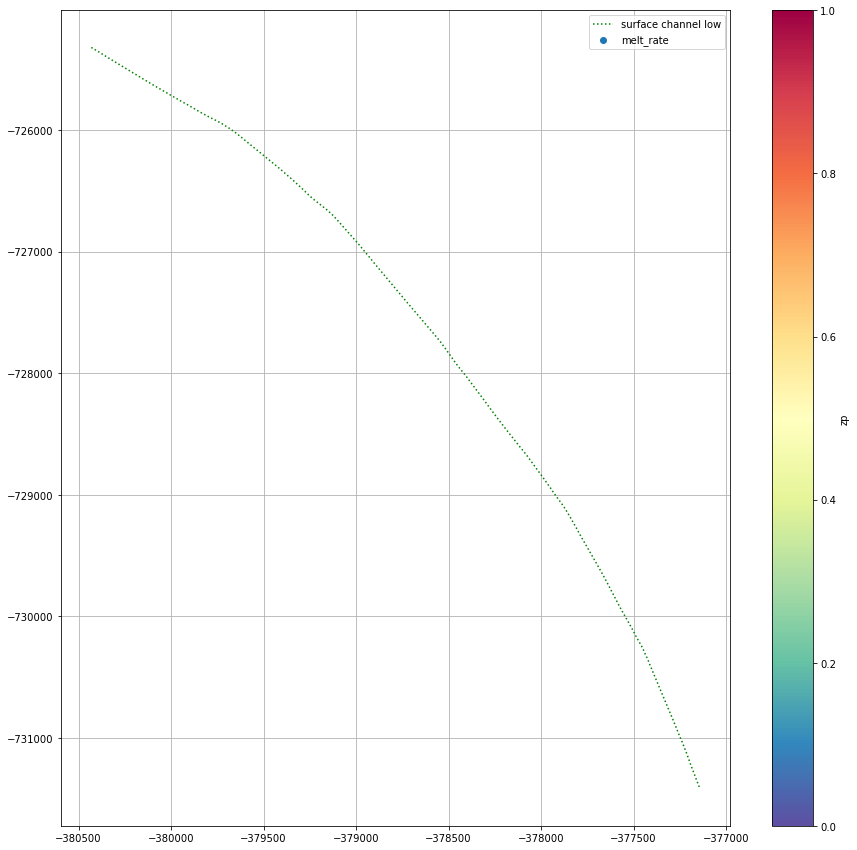

In [9]:
map_track(track,show='zp')

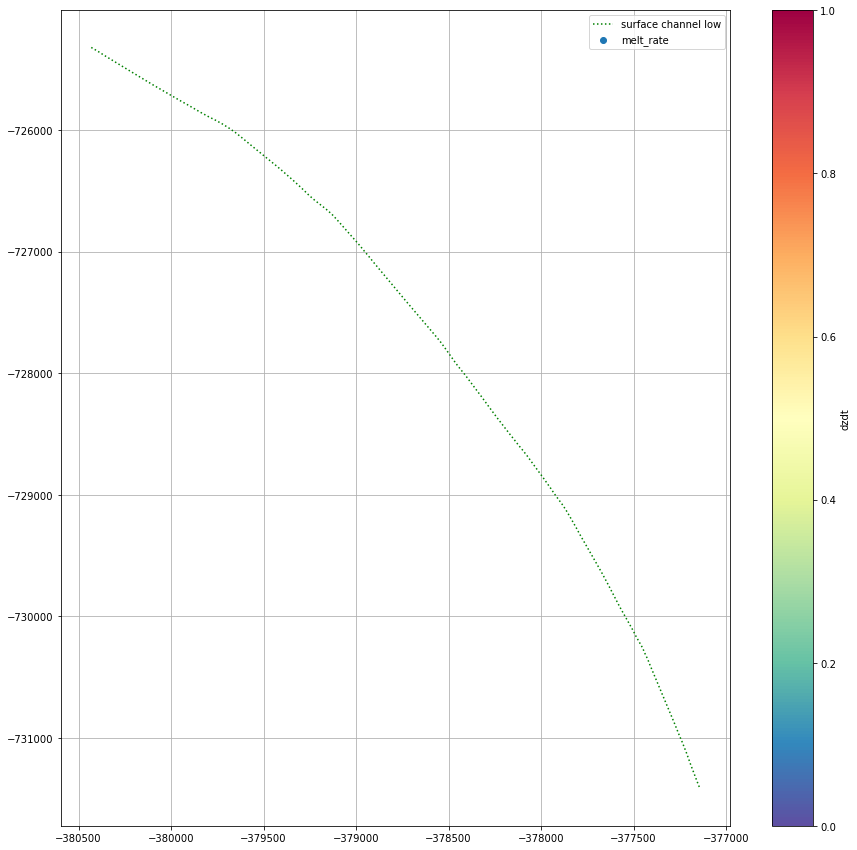

In [10]:
map_track(track,show='dzdt')

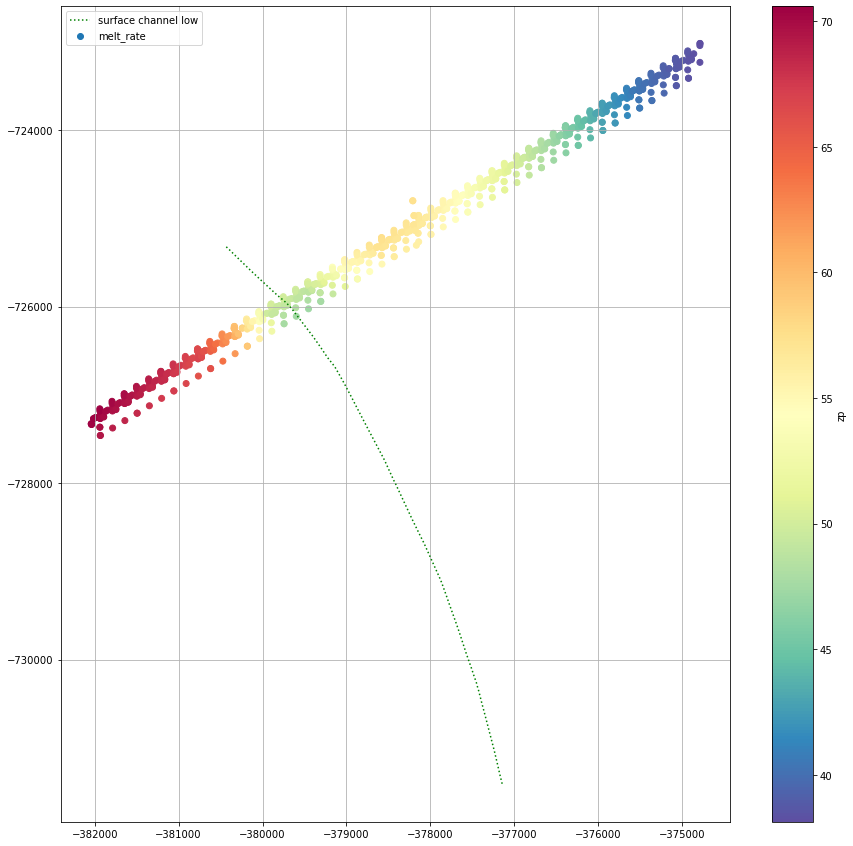

In [11]:
map_track('track0211',show='zp')

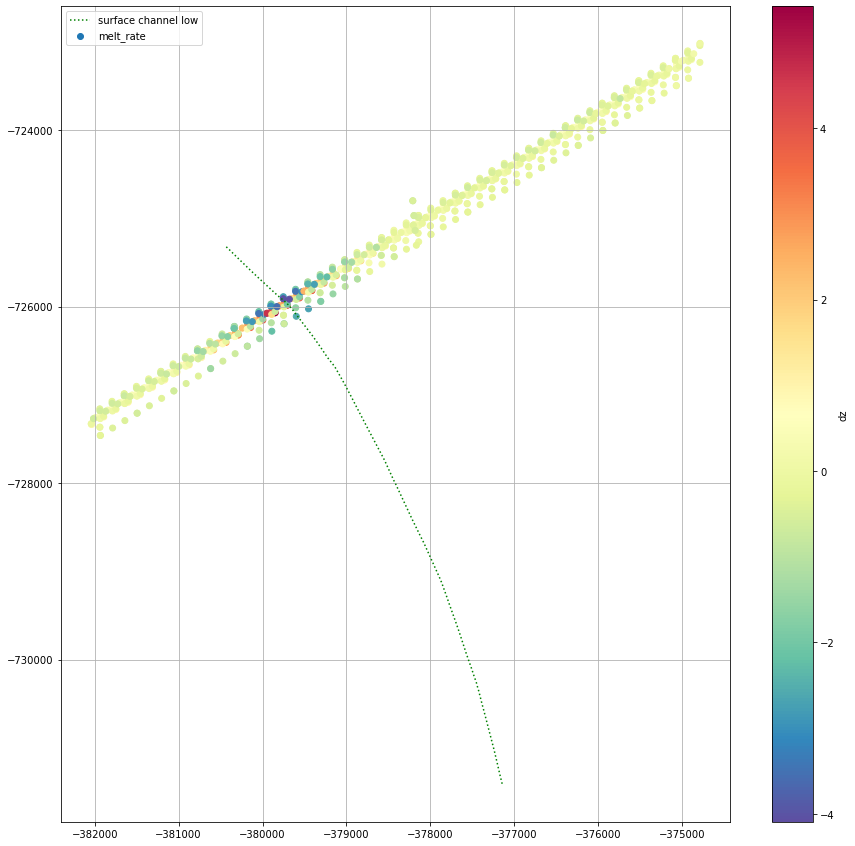

In [12]:
map_track('track0211',show='dz')

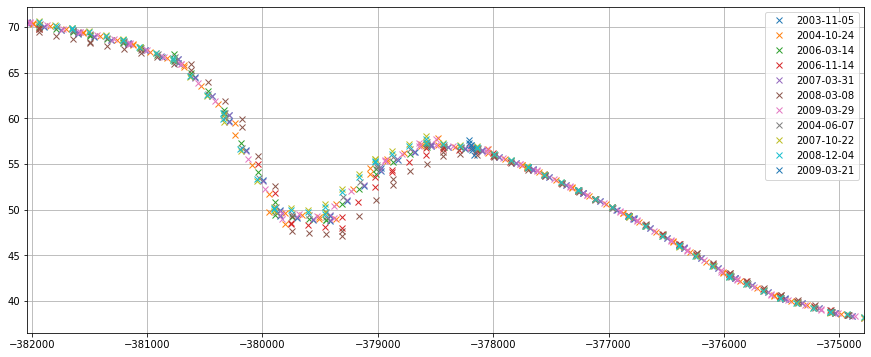

In [20]:
crosssection('track0211',x_or_y = 'x', show='zp')

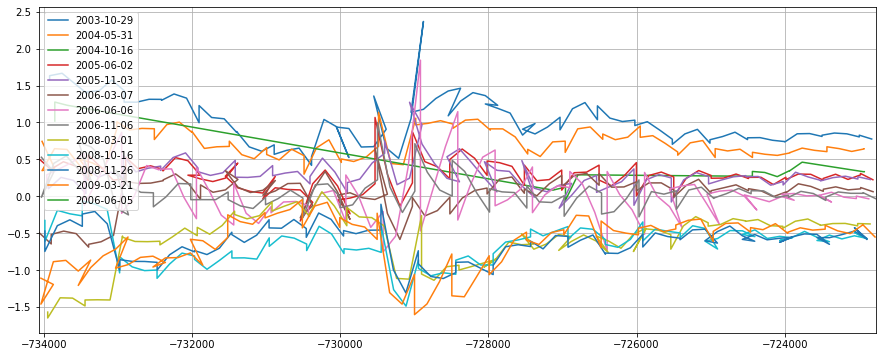

In [14]:
crosssection('track0099',show='dz')

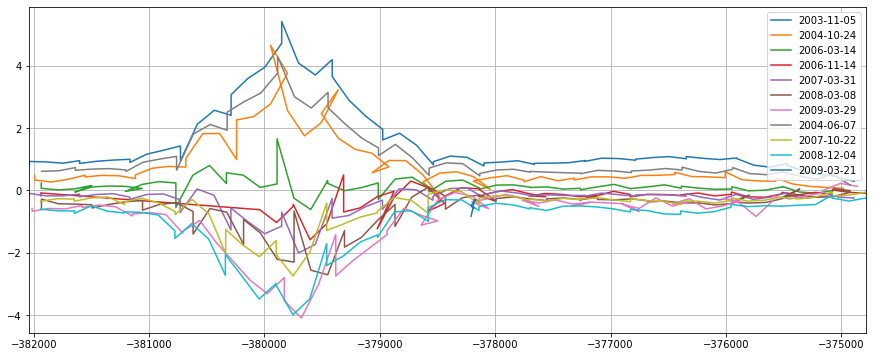

In [15]:
crosssection('track0211',x_or_y='x',show='dz')

# get resonable dzdt for each line

In [16]:
def crosssection(track,show='zp'):
    track = 'track0099'
    da = icesat1_load_alldzdt_pickle(track)
    gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")
    
    plt.figure(figsize=(15,6))
    for pass_date in da.timestamp.dt.date.unique():
        min(pass_date)
        daa = da[da.timestamp.dt.date==pass_date]
        plt.plot(daa.y,daa[show],'x',label=pass_date)
    plt.xlim([da.y.min(),da.y.max()])
    plt.legend()
    plt.grid()
    
    
da['try'] = da.zp - 

res = z - zp;     % transient changes (footprint elevation changes corrected for
                % slope and secular change. Note here we use z here (not elev)

dz=res + ((t - t0).*bindzdt);   % Elevation change corrected for each segment. This is
                % corrected for gradient. Note, this is per day.

SyntaxError: invalid syntax (<ipython-input-16-2dd1a9366008>, line 16)

In [ ]:
track = 'track0099'

path = f'/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/dataframe_{track}_alldzdt.pkl'
    
da = pd.read_pickle(path)

In [ ]:
for b in da.bin_number.unique():
    print(b)

In [ ]:
df0099 = icesat1_alldzdt_todataframe('track0099') 

In [ ]:
df0099.to_pickle('/Users/home/whitefar/DATA/df0099.pkl')

In [ ]:
with h5py.File(path, 'r') as f:

    bins = list(f['dzdt'][track].keys())
len(bins)

In [ ]:
#trying to find the right track, which has more points over the channel
lengths = []
for track in tracks:
    df = icesat1_alldzdt_todataframe(track) 
    lengths.append(df.shape[0])
    print(track,df.shape[0])
    del df

In [ ]:
icesat1_alldzdt_todataframe('track0365')

In [ ]:
df = df0099

In [ ]:
track = 'track0099'
b='bin10000'
path = f'/Users/home/horganhu/ICESAT_LINK/TAMATA_ICESAT/GLA12_633_DZDT/{track}_all_dzdt.mat'
with h5py.File(path, 'r') as f:
    a = f['dzdt'][track][b]['x'][0]
a.shape[0]
    


### from load_matlab_icesat1_structures we see the tracks over the channel with  the most data
track number_of_datapoints
track0015 0
track1331 68
track0043 0
track0197 68
track1303 68
track0351 68
track0057 0
track0407 68
track0155 68
track0127 68
track0183 68
track0365 68
track0337 68
track0099 753
track0295 68
track0323 68
track0211 549
track0113 68
track0379 68
track0085 193
track0267 68
track0071 0
track0169 68
track1289 68
track0029 0
track1345 68
track0239 68
track1275 68
track0225 68
track0001 0
track0393 68
track0141 68
track0253 68
track0309 68
track1317 68
track0281 68

In [ ]:
df0099 = icesat1_alldzdt_todataframe('track0099')

In [ ]:
df0099.x

In [ ]:
df0099.zp

In [ ]:
df = df0099.copy()

In [ ]:
df0099['bin10000'].keys()

In [ ]:
len(df0099['bin99999']['z'])

In [ ]:
df0099['bin99999']['sdatedays']

In [ ]:
with h5py.File(path, 'r') as f:
    bins = list(f['dzdt']['track0099'].keys())

In [ ]:
bins

In [ ]:
b = bins[-5]
with h5py.File(path, 'r') as f:
    print(f['dzdt']['track0099'][b]['x'][0][:5])

In [ ]:
track = '0099'
path = f'/Users/home/horganhu/ICESAT_LINK/TAMATA_ICESAT/GLA12_633_DZDT/track{track}_all_dzdt.mat'

In [ ]:
df = pd.DataFrame({'x':[],
                   'pass_num':[],
                  })
psys = []
h = []
UTCtime = []
dh = []

with h5py.File(path, 'r') as f:
    #add x location
    psx_l = list(f['antarctica'][track]['psx'])
    for p in psx_l:
        df_temp = pd.DataFrame({'x': list(f['antarctica'][track]['psx'][p][0]),
                                'pass_num': [p]*len(list(f['antarctica'][track]['psx'][p])[0]) })
        df = df.append(df_temp , ignore_index=True )

#     #add y location
#     psy_l = list(f['antarctica'][track]['psy'])
#     for p in psy_l:
#         psys.extend( list(f['antarctica'][track]['psy'][p][0]) )

#     #add height
#     h_l = list(f['antarctica'][track]['elev_wgs84_retide'])
#     for p in h_l:
#         h.extend( list(f['antarctica'][track]['elev_wgs84_retide'][p][0]) )

#     #add time
#     t_l = list(f['antarctica'][track]['UTCTime'])
#     for p in t_l:
#         UTCtime.extend( list(f['antarctica'][track]['UTCTime'][p][0]) )

#     #add delta_h (not sure what it is)
#     dh_l = list(f['antarctica'][track]['delta_h'])
#     for p in dh_l:
#         dh.extend( list(f['antarctica'][track]['delta_h'][p][0]) )

In [ ]:
df = icesat1todataframe('track0099')

In [ ]:
len([12,3])

In [ ]:
zp = [x-mean(x); y-mean(y)]'*grad + (t-t0)'*(bindzdt) + mean(z); % Note here we use z here (not elev)

zp=zp';

res = z - zp;     % transient changes (footprint elevation changes corrected for
                % slope and secular change. Note here we use z here (not elev)

dz=res + ((t - t0).*bindzdt);   % Elevation change corrected for each segment. This is
                % corrected for gradient. Note, this is per day.